In [2]:
!rm -rf PCB-Diffusion-AD

In [3]:
!git clone https://github.com/nguyenduchuyiu/PCB-Diffusion-AD.git

Cloning into 'PCB-Diffusion-AD'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 88 (delta 43), reused 69 (delta 24), pack-reused 0 (from 0)
Receiving objects: 100% (88/88), 55.63 KiB | 2.42 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [4]:
%cd PCB-Diffusion-AD

/workspace/PCB-Diffusion-AD


In [6]:
%%writefile args/args1.json
{
  "img_size": [256,256],
  "Batch_Size": 16,
  "EPOCHS": 500,
  "T": 1000,
  "base_channels": 128,
  "beta_schedule": "linear",
  "loss_type": "l2",
  "diffusion_lr": 1e-4,
  "seg_lr": 1e-5,
  "random_slice": true,
  "weight_decay": 0.0,
  "save_imgs":true,
  "save_vids":false, 
  "dropout":0,
  "attention_resolutions":"32,16,8",
  "num_heads":4,
  "num_head_channels":-1,
  "noise_fn":"gauss",
  "channels":3,
  "data_name":"RealIAD",
  "data_root_path":"./",
  "anomaly_source_path":"./dtd",
  "noisier_t_range":600,
  "less_t_range":300,
  "condition_w":1,
  "eval_normal_t":200,
  "eval_noisier_t":400,
  "output_path":"outputs",
  "gradient_accumulation_steps": 1,
  "use_mixed_precision": true,
  "resume_training": true
}


Overwriting args/args1.json


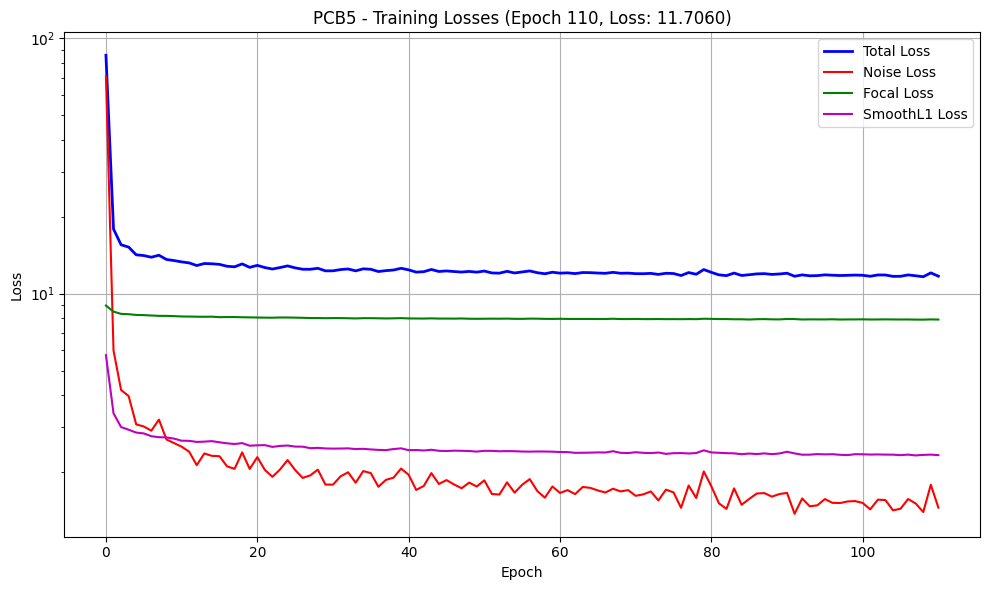

📊 Loss tracking: Epoch 110, Loss: 11.7060


Epoch:111, Train loss: 8.675:  73%|███████▎  | 90/123 [01:04<00:22,  1.44it/s]

In [ ]:
from random import seed
import torch
import os
import json
import matplotlib.pyplot as plt
import numpy as np
from torch import optim
from torch.utils.data import DataLoader
from models.Recon_subnetwork import UNetModel, update_ema_params
from models.Seg_subnetwork import SegmentationSubNetwork
from tqdm import tqdm
import torch.nn as nn
from data.dataset_beta_thresh import RealIADTrainDataset, RealIADTestDataset
from math import exp
import torch.nn.functional as F
from models.DDPM import GaussianDiffusionModel, get_beta_schedule
from scipy.ndimage import gaussian_filter
from skimage.measure import label, regionprops
from sklearn.metrics import roc_auc_score,auc,average_precision_score
import pandas as pd
from collections import defaultdict
from train import defaultdict_from_json, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Check for multiple GPUs
num_gpus = torch.cuda.device_count()
print(f"Number of available GPUs: {num_gpus}")
if num_gpus > 1:
    print(f"Using {num_gpus} GPUs for training")
elif num_gpus == 1:
    print("Using single GPU for training")
else:
    print("Using CPU for training")

# read file from argument
file = "args1.json"
# load the json args
with open(f'./args/{file}', 'r') as f:
    args = json.load(f)
args['arg_num'] = file[4:-5]
args = defaultdict_from_json(args)


real_iad_classes = os.listdir(os.path.join(args["data_root_path"], args['data_name']))

for sub_class in real_iad_classes:   
    print("class", sub_class)
    
    subclass_path = os.path.join(args["data_root_path"], args['data_name'], sub_class)
    
    training_dataset = RealIADTrainDataset(
        subclass_path, sub_class, img_size=args["img_size"], args=args
    )
    testing_dataset = RealIADTestDataset(
        subclass_path, sub_class, img_size=args["img_size"]
    )
    class_type=args['data_name']
    

    print(file, args)     

    data_len = len(testing_dataset)
    
    # Calculate effective batch size considering multi-GPU and gradient accumulation
    base_batch_size = args['Batch_Size']
    gradient_accumulation_steps = args.get('gradient_accumulation_steps', 1)
    
    # For DataLoader, we use the base batch size
    dataloader_batch_size = base_batch_size
    
    # Total effective batch size
    total_effective_batch_size = dataloader_batch_size * gradient_accumulation_steps
    
    print(f"Batch size configuration:")
    print(f"  - Base batch size: {base_batch_size}")
    print(f"  - DataLoader batch size: {dataloader_batch_size} ({'Multi-GPU' if num_gpus > 1 else 'Single-GPU'})")
    print(f"  - Gradient accumulation steps: {gradient_accumulation_steps}")
    print(f"  - Total effective batch size: {total_effective_batch_size}")
    
    training_dataset_loader = DataLoader(training_dataset, batch_size=dataloader_batch_size,shuffle=True,num_workers=8,pin_memory=True,drop_last=True)
    test_loader = DataLoader(testing_dataset, batch_size=1,shuffle=False, num_workers=4)

    # make arg specific directories
    for i in [f'{args["output_path"]}/model/diff-params-ARGS={args["arg_num"]}/{sub_class}',
            f'{args["output_path"]}/diffusion-training-images/ARGS={args["arg_num"]}/{sub_class}',
             f'{args["output_path"]}/metrics/ARGS={args["arg_num"]}/{sub_class}']:
        try:
            os.makedirs(i)
        except OSError:
            pass


    train(training_dataset_loader, test_loader, args, data_len,sub_class,class_type,device, num_gpus)

In [ ]:
import torch, gc

gc.collect() 
torch.cuda.empty_cache()  
torch.cuda.ipc_collect()  
from eval import testing, load_parameters, defaultdict_from_json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Check for multiple GPUs
num_gpus = torch.cuda.device_count()
print(f"Number of available GPUs: {num_gpus}")
if num_gpus > 1:
    print(f"Using {num_gpus} GPUs for evaluation")
elif num_gpus == 1:
    print("Using single GPU for evaluation")
else:
    print("Using CPU for evaluation")
file = "args1.json"
# load the json args
with open(f'./args/{file}', 'r') as f:
    args = json.load(f)
args['arg_num'] = file[4:-5]
args = defaultdict_from_json(args)
real_iad_classes = os.listdir(os.path.join(args["data_root_path"], args['data_name']))

current_classes = real_iad_classes
checkpoint_types = ['best', 'last']

for sub_class in current_classes:
    for checkpoint_type in checkpoint_types:
        try:
            args, output = load_parameters(device, sub_class, checkpoint_type)
        except FileNotFoundError:
            print(f"Checkpoint {checkpoint_type} not found for class {sub_class}, skipping.")
            continue

        print(f"args{args['arg_num']}")
        print("class", sub_class)
        
        in_channels = args["channels"]

        unet_model = UNetModel(args['img_size'][0], args['base_channels'], channel_mults=args['channel_mults'], dropout=args[
                    "dropout"], n_heads=args["num_heads"], n_head_channels=args["num_head_channels"],
                in_channels=in_channels
                ).to(device)

        seg_model = SegmentationSubNetwork(in_channels=6, out_channels=1).to(device)

        # Load model states
        unet_model.load_state_dict(output["unet_model_state_dict"])
        unet_model.to(device)
        
        seg_model.load_state_dict(output["seg_model_state_dict"])
        seg_model.to(device)
        
        # Enable multi-GPU for evaluation if available
        if num_gpus > 1:
            print(f"Wrapping models with DataParallel for {num_gpus} GPUs")
            unet_model = torch.nn.DataParallel(unet_model)
            seg_model = torch.nn.DataParallel(seg_model)
        
        unet_model.eval()
        seg_model.eval()

        print("EPOCH:", output['n_epoch'])

        testing_dataset = RealIADTestDataset(
            args["data_root_path"], sub_class, img_size=args["img_size"]
        )
        class_type = args['data_name']
                
        data_len = len(testing_dataset) 
        test_loader = DataLoader(testing_dataset, batch_size=1, shuffle=False, num_workers=4)

        # make arg specific directories
        for i in [f'{args["output_path"]}/metrics/ARGS={args["arg_num"]}/{sub_class}']:
            try:
                os.makedirs(i)
            except OSError:
                pass

        testing(test_loader, args, unet_model, seg_model, data_len, sub_class, class_type, checkpoint_type, device)


In [ ]:
import sys
!{sys.executable} -m pip install matplotlib